# Disclaimer
This material was prepared as an account of work sponsored by an agency of the United States Government.  Neither the United States Government nor the United States Department of Energy, nor Battelle, nor any of their employees, nor any jurisdiction or organization that has cooperated in the development of these materials, makes any warranty, express or implied, or assumes any legal liability or responsibility for the accuracy, completeness, or usefulness or any information, apparatus, product, software, or process disclosed, or represents that its use would not infringe privately owned rights.

Reference herein to any specific commercial product, process, or service by trade name, trademark, manufacturer, or otherwise does not necessarily constitute or imply its endorsement, recommendation, or favoring by the United States Government or any agency thereof, or Battelle Memorial Institute. The views and opinions of authors expressed herein do not necessarily state or reflect those of the United States Government or any agency thereof.

                            PACIFIC NORTHWEST NATIONAL LABORATORY
                                        operated by
                                         BATTELLE
                                          for the
                             UNITED STATES DEPARTMENT OF ENERGY
                              under Contract DE-AC05-76RL01830

# `GenX` Demonstration
This notebook demonstrates how to prepare a document corpus for the `GenX` tool. The general workflow is to:
* Read in and clean the data
    * in this example we use the 20 newsgropus data which is a good candidate for having train/test contamination, e.g. original emails and replies, repeated email signatures, etc.
* Split the data into "train" and "test" sets
    * this is done the typical way if you want to test for train/test contamination, e.g., in this demonstration
    * if you are working with a conditional natural language generation model, this will be the train set and the generated set
* Perform sentence tokenization and explode
    * each sentence becomes a row in the data)
    * the original document id is maintained as an attribute
* Calculate embeddings on each sentence
    * there are many choices, we use an arbitrary one from `sentence_transformers`
* Pass the above data to the `GenX` widget and explore!

## Ingestion and Cleaning

In [1]:
import numpy as np
import pandas as pd
import re
from nltk import sent_tokenize
from sklearn.datasets import fetch_20newsgroups

data = fetch_20newsgroups()

def parse_document(s):
    header, content = s.split('\n\n', 1)
    source, title, _ = header.split('\n', 2)
    return {'source': source.replace('From:', ''),
            'title': title.replace('Subject: ', ''),
            'cleaned_text': content.strip()}

df = pd.DataFrame(map(parse_document, data.data))\
    .assign(topic=np.array(data.target_names)[data.target])

# some documents are empty (just the title), drop those
df = df[(df.cleaned_text.apply(len) > 0)]

# strip out of some of the reply formatting that would interfere with tokenization
# then tokenize
df['cleaned_text'] = df.cleaned_text.str.replace(r'\n+>{0,1}', ' ')\
    .apply(sent_tokenize)

df.index = df.index.astype('str')
df.index.name = 'email_uuid'

df.dropna()

,source,title,cleaned_text,topic
email_uuid,,,,
0,lerxst@wam.umd.edu (where's my thing),WHAT car is this!?,[I was wondering if anyone out there could enl...,rec.autos
1,guykuo@carson.u.washington.edu (Guy Kuo),SI Clock Poll - Final Call,[A fair number of brave souls who upgraded the...,comp.sys.mac.hardware
2,twillis@ec.ecn.purdue.edu (Thomas E Willis),PB questions...,"[well folks, my mac plus finally gave up the g...",comp.sys.mac.hardware
3,jgreen@amber (Joe Green),Re: Weitek P9000 ?,[Robert J.C. Kyanko (rob@rjck.UUCP) wrote: ab...,comp.graphics
4,jcm@head-cfa.harvard.edu (Jonathan McDowell),Re: Shuttle Launch Question,"[From article <C5owCB.n3p@world.std.com>, by t...",sci.space
...,...,...,...,...
11309,jim.zisfein@factory.com (Jim Zisfein),Re: Migraines and scans,[DN> From: nyeda@cnsvax.uwec.edu (David Nye) D...,sci.med
11310,ebodin@pearl.tufts.edu,Screen Death: Mac Plus/512,"[I have a (very old) Mac 512k and a Mac Plus, ...",comp.sys.mac.hardware
11311,westes@netcom.com (Will Estes),Mounting CPU Cooler in vertical case,[I just installed a DX2-66 CPU in a clone moth...,comp.sys.ibm.pc.hardware


## Train/Test Split, reshaping for embeddings

In [2]:
sorted(set(df.topic))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [3]:
from sklearn.model_selection import train_test_split

topics = {
    'sci.space'
}

train, test = train_test_split(df[df.topic.apply(topics.__contains__)])
train_sent = train.explode('cleaned_text').reset_index()
test_sent = test.explode('cleaned_text').reset_index()

train_sent

,email_uuid,source,title,cleaned_text,topic
0,1239,clarke@acme.ucf.edu (Thomas Clarke),Re: pushing the envelope,> In <1993Apr3.233154.7045@Princeton.EDU> lije...,sci.space
1,1239,clarke@acme.ucf.edu (Thomas Clarke),Re: pushing the envelope,Anyone out there know?,sci.space
2,1239,clarke@acme.ucf.edu (Thomas Clarke),Re: pushing the envelope,Everbody has been defining envelope.,sci.space
3,1239,clarke@acme.ucf.edu (Thomas Clarke),Re: pushing the envelope,"Why was the world ""envelope"" chosen, rather th...",sci.space
4,1239,clarke@acme.ucf.edu (Thomas Clarke),Re: pushing the envelope,In analogy with the envelopes of airships perh...,sci.space
...,...,...,...,...,...
6879,2861,"zowie@daedalus.stanford.edu (Craig ""Powderkeg...",Re: Cold Gas tanks for Sounding Rockets,This should give you an idea of the order of m...,sci.space
6880,2861,"zowie@daedalus.stanford.edu (Craig ""Powderkeg...",Re: Cold Gas tanks for Sounding Rockets,"If you really need to know, send me email and ...",sci.space
6881,2861,"zowie@daedalus.stanford.edu (Craig ""Powderkeg...",Re: Cold Gas tanks for Sounding Rockets,"Cheers, Craig -- DON'T DRINK SOAP!",sci.space
6882,2861,"zowie@daedalus.stanford.edu (Craig ""Powderkeg...",Re: Cold Gas tanks for Sounding Rockets,DILUTE DILUTE!,sci.space


## Run the embedding model
Warning: without sampling or subsetting based on topic, this may take several hours.

In [4]:
#!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-distilroberta-base-v1')

def get_embedding(df):
    return pd.DataFrame(model.encode(df.cleaned_text), index=df.index)

train_emb = get_embedding(train_sent)
test_emb = get_embedding(test_sent)

train_emb

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.317082,-0.084372,-0.143844,0.168914,-0.219328,0.007308,-0.028128,0.210935,-0.112701,0.164928,...,0.076167,0.134254,0.361020,0.348300,-0.422083,0.031288,0.445350,-0.383166,0.004717,0.207840
1,0.221861,-0.436218,-0.113495,-0.046161,-0.028469,0.046753,-0.009441,0.416138,0.269982,-0.010351,...,-0.112625,-0.172222,-0.617730,-0.278244,-0.024918,0.069944,0.042029,0.264057,0.107960,-0.119853
2,0.152124,0.019417,-0.290834,-0.558308,0.296495,-0.153209,-0.191580,0.177581,0.170796,0.269987,...,0.114788,-0.179452,0.133029,0.298828,0.082279,0.147859,0.557373,-0.203178,0.108659,0.120023
3,-0.013242,0.101990,0.113185,0.049243,0.320582,-0.041461,0.089460,-0.046205,0.165794,-0.129755,...,-0.018858,-0.308431,-0.204261,0.351190,0.178528,0.171147,-0.577631,-0.002384,0.175017,0.153673
4,-0.199818,-0.105428,0.070448,-0.249744,-0.088174,-0.019315,-0.173607,-0.340877,-0.020673,-0.356303,...,-0.283526,-0.179094,0.100488,0.001828,-0.082127,-0.283278,0.488701,-0.625340,0.081700,-0.212471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6879,0.153467,0.006784,0.050614,-0.289252,0.034616,-0.164451,0.122197,0.018691,0.054815,-0.183197,...,0.089246,-0.139668,-0.177853,0.140187,-0.123811,-0.172556,0.505756,0.222962,0.443472,-0.340995
6880,0.006382,0.204148,-0.300662,-0.190159,-0.267596,-0.276759,-0.050337,-0.115164,0.591530,-0.177117,...,0.373178,-0.204173,0.020981,0.043029,-0.020093,0.141921,0.555382,-0.211514,-0.170825,0.344191
6881,-0.197526,-0.024066,-0.056746,-0.536938,0.005906,0.210153,0.281594,-0.165753,-0.136828,-0.044518,...,0.103221,-0.185240,-0.066152,0.064562,0.623562,-0.062191,-0.564461,-0.422010,-0.120550,0.064880
6882,0.006617,0.241303,-0.112717,-0.028096,-0.164031,0.352957,-0.105696,0.382546,0.365771,-0.079608,...,0.238116,-0.491030,0.640744,-0.080268,0.154063,-0.072150,0.072759,0.008835,-0.145033,-0.146857


## Run `GenX`

In [5]:
from genx import GenX

cols = ['cleaned_text', 'email_uuid']

self = GenX(
    train_sent[cols],
    train_emb,
    test_sent[cols],
    test_emb,
    metric='cosine',
    n_neighbors=10
)

self

GenX(component='GenX', props={'train': {'index': [0, 1, 2, 5, 6, 8, 9, 10, 12, 13, 14, 16, 17, 18, 19, 20, 21,…

## Access some of the pre-computed stats

<AxesSubplot:xlabel='diversity', ylabel='closeness'>

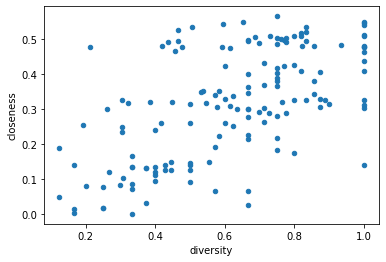

In [6]:
self.stats.plot.scatter('diversity', 'closeness')

In [7]:
# save props for live demo
import json
with open('../demo/src/props.json', 'w') as fp:
    json.dump(self.props, fp)